**EJERCICIO ENTREGABLE M7_DEEP LEARNING - CLASIFICACIÓN RADIOGRAFÍAS DE TORAS: NEUMONÍA VS NORMAL**

Resumen del caso práctico:
    1.Contexto: Tenemos imágenes de rayos X de tórax de pacientes pediátricos que han sido revisadas por expertos médicos.
    2. Objetivo: Entrenar una red neuronal convolucional (CNN) que clasifique correctamente las radiografías con una precisión superior al 80%, para ayudar a los médicos a priorizar casos urgentes.
    3. Datos:
        - 5,863 imágenes de rayos X en formato JPEG
        - 2 categorías: neumonía y normal
        - Organizadas en 3 carpetas: train, test y val
        - Cada carpeta tiene subcarpetas para cada categoría
4. Tareas a realizar:
    Ejercicio 1: Cargar los datos y visualizar las imágenes
    Ejercicio 2: Construir, compilar y entrenar la red CNN
    Ejercicio 3: Crear curvas para evaluar la generalización y detectar posible overfitting
    Ejercicio 4: Hacer predicciones sobre las imágenes de la carpeta de validación
5. Entregable: Un notebook ejecutado que documente las decisiones tomadas durante el desarrollo.

# 1. Preparación del ejercicio

In [5]:
# 1. Preparación del ejercicio

# Importamos las librerías necesarias
import numpy as np  # Para operaciones numéricas y arrays
import pandas as pd  # Para manipulación de datos tabulares
import matplotlib.pyplot as plt  # Para visualización de gráficos
import seaborn as sns  # Para visualización estadística
import os  # Para interactuar con el sistema operativo
import random  # Para generar números aleatorios
from PIL import Image  # Para manipular imágenes

# Instalamos TensorFlow si no está disponible
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.6/259.6 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.0/277.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 42.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 28.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 41.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.8/389.8 kB 7.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 1.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 37.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29

In [10]:
# Ahora importamos TensorFlow y sus componentes
import tensorflow as tf  # Biblioteca principal para deep learning
print("TensorFlow instalado correctamente. Versión:", tf.__version__)

# Importamos componentes específicos de Keras (parte de TensorFlow)
from tensorflow.keras.models import Sequential  # Para crear modelos secuenciales
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # Capas para CNN
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Para preprocesamiento de imágenes
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # Para controlar el entrenamiento

# Verificamos si tenemos GPU disponible
print("GPU disponible:", tf.config.list_physical_devices('GPU'))
if not tf.config.list_physical_devices('GPU'):
    print("No se detectó GPU. El entrenamiento será más lento usando CPU.")
else:
    print("¡Genial! Tienes GPU disponible. El entrenamiento será más rápido.")

# Configuramos el estilo de gráficos (sin usar comandos mágicos)
plt.style.use('ggplot')  # Estilo de gráficos

TensorFlow instalado correctamente. Versión: 2.16.2
GPU disponible: []
No se detectó GPU. El entrenamiento será más lento usando CPU.


In [12]:
# Desactivar los warnings
import warnings
warnings.filterwarnings("ignore")

# 2. Preparación de los datos

In [18]:
# Definimos los directorios donde están nuestros datos
base_dir = '/Users/maruxamoreiraperez/Python/MaruPython/clases julio/modulo 7/Deep learning/data copia'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

# Verificamos si los directorios existen
print(f"¿Existe el directorio de entrenamiento? {os.path.exists(train_dir)}")
print(f"¿Existe el directorio de prueba? {os.path.exists(test_dir)}")
print(f"¿Existe el directorio de validación? {os.path.exists(val_dir)}")

# Separamos los datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Tamaño de las imágenes y batch size
img_width, img_height = 64, 64
batch_size = 32

# Generadores para cargar las imágenes
training_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

testing_dataset = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_dataset = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

# Mostramos información sobre los conjuntos de datos
print("\nInformación de los conjuntos de datos:")
print(f"Clases en el conjunto de entrenamiento: {training_dataset.class_indices}")
print(f"Número de imágenes de entrenamiento: {training_dataset.samples}")
print(f"Número de imágenes de prueba: {testing_dataset.samples}")
print(f"Número de imágenes de validación: {validation_dataset.samples}")

¿Existe el directorio de entrenamiento? True
¿Existe el directorio de prueba? True
¿Existe el directorio de validación? True
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 14 images belonging to 2 classes.

Información de los conjuntos de datos:
Clases en el conjunto de entrenamiento: {'NORMAL': 0, 'PNEUMONIA': 1}
Número de imágenes de entrenamiento: 5216
Número de imágenes de prueba: 624
Número de imágenes de validación: 14


# 3. Modelo CNN

## 3.1 Crear el modelo

In [29]:
classifier = Sequential()

# Primera capa convolucional
classifier.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa convolucional
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Tercera capa convolucional
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanar
classifier.add(Flatten())

# Capa completamente conectada
classifier.add(Dense(units=64, activation='relu'))
classifier.add(Dropout(0.5))  # Para evitar el sobreajuste
classifier.add(Dense(units=1, activation='sigmoid'))  # Salida binaria (NORMAL o PNEUMONIA)

# Compilar el modelo
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Mostrar resumen del modelo
classifier.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,225 (688.38 KB)

 Trainable params: 176,225 (688.38 KB)

 Non-trainable params: 0 (0.00 B)

## 3.2 Entrenar el modelo

In [31]:
# 4. Entrenar el modelo

# Entrenamos el modelo con los datos
history = classifier.fit(
    training_dataset,
    steps_per_epoch=training_dataset.samples // batch_size,
    epochs=25,
    validation_data=validation_dataset,
    validation_steps=validation_dataset.samples // batch_size)

Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 545ms/step - accuracy: 0.7341 - loss: 0.5751 - val_accuracy: 0.9286 - val_loss: 0.4429
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 541ms/step - accuracy: 0.8620 - loss: 0.3100 - val_accuracy: 0.7857 - val_loss: 0.4544
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 530ms/step - accuracy: 0.8940 - loss: 0.2624 - val_accuracy: 0.7857 - val_loss: 0.3707
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 521ms/step - accuracy: 0.9159 - loss: 0.2169 - val_accuracy: 0.8571 - val_loss: 0.4942
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 520ms/step - accuracy: 0.9118 - loss: 0.2192 - val_accuracy: 0.7857 - val_loss: 0.4421
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 526ms/step - accuracy: 0.9325 - loss: 0.1840 - val_accuracy: 0.5714 - val_loss: 0.7267
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 522ms/step - accuracy: 0.9289 - loss: 0.1843 - val_accuracy: 0.7143 - val_loss: 0.3974
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 1838s 11s/step - accuracy: 0.9403 - loss: 0

## 3.3. Evaluar el modelo
Evaluamos qué tan bien funciona el modelo con datos que no ha visto en el entrenamiento

In [33]:
# Evaluamos el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc = classifier.evaluate(testing_dataset)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 425ms/step - accuracy: 0.8967 - loss: 0.3057
Precisión en el conjunto de prueba: 0.9071


El modelo con el conjunto de prueba obtine una precisión del 90.71%

Entrenamos el modelo con los siguientes parámetros:
- epochs=25: El modelo verá los datos de entrenamiento 25 veces
- batch_size=32: Procesa 32 imágenes en cada paso
- validation_data: Usamos el conjunto de validación para monitorear el rendimiento

El entrenamiento muestra:
- accuracy: Precisión en datos de entrenamiento
- val_accuracy: Precisión en datos de validación
- loss: Pérdida en entrenamiento
- val_loss: Pérdida en validación

Observamos que el modelo alcanza una precisión de entrenamiento superior al 90% a partir de la Epoch 10


Avg. Train Accuracy: 93.4
Avg. Test Accuracy: 78.86
Avg. Train Loss: 17.0
Avg. Test Loss: 45.050000000000004


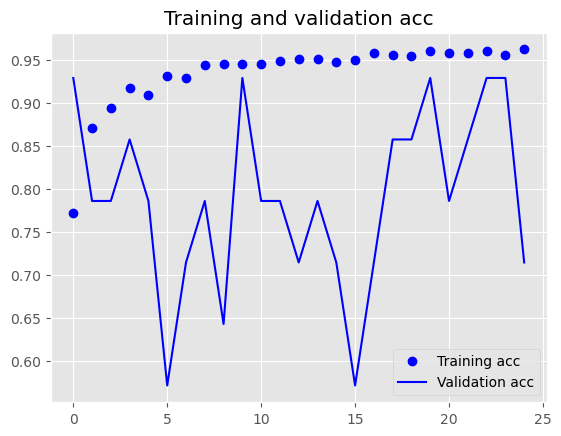

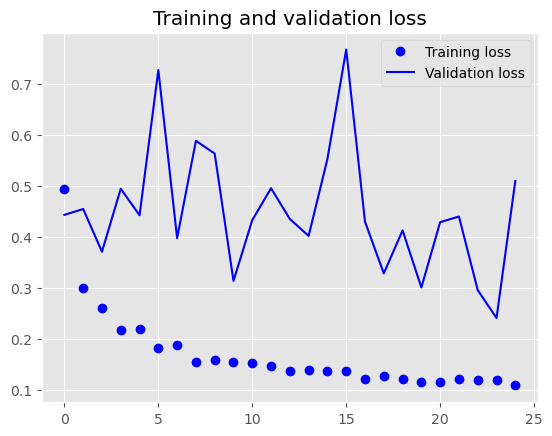

In [37]:
# Obtenemos los datos de precisión y pérdida del entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Calculamos los promedios
print(f"Avg. Train Accuracy: {round(np.mean(acc),3)*100}")
print(f"Avg. Test Accuracy: {round(np.mean(val_acc),4)*100}")
print(f"Avg. Train Loss: {round(np.mean(loss),3)*100}")
print(f"Avg. Test Loss: {round(np.mean(val_loss),4)*100}")

# Creamos un rango para el eje x (número de Epoch)
epochs = range(len(acc))

# Gráfica de precisión
plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Conclusiones:

1. Resultados:
   - Precisión en entrenamiento: 93.4%
   - Precisión en validación: 78.86%

3. Análisis:
   - El modelo muestra buen rendimiento general (90.71% en prueba)
   - Existe sobreajuste: diferencia de aproximadamente 15% entre entrenamiento y validación
   - Las fluctuaciones en validación se deben al pequeño conjunto (14 imágenes)

4. Para mejorar el modelo podemos:
   - Aumentar el conjunto de validación
   - Implementar Early Stopping
   - Mejorar el data augmentation

El modelo cumple el objetivo principal pero puede optimizarse para mayor robustez
y estabilidad en las predicciones.

# 4. Optimización del modelo

Basándonos en las conclusiones anteriores, vamos a implementar las siguientes mejoras
en orden de prioridad:

1. Redistribución de datos:
   - Moveremos algunas imágenes del conjunto de entrenamiento al de validación
   - Objetivo: tener al menos 100 imágenes en validación

2. Early Stopping:
   - Implementaremos un callback de Early Stopping
   - Detendrá el entrenamiento cuando la pérdida de validación deje de mejorar
   - Evitará el sobreentrenamiento

3. Mejora del Data Augmentation:
   - Añadiremos más transformaciones a las imágenes
   - Ayudará a reducir el sobreajuste

Implementaremos estos cambios uno a uno para poder evaluar su impacto.

## 4.1 Implementación de Early Stopping

In [39]:
# 1. Configuramos un Early Stopping más robusto
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',      # Monitorizamos la pérdida en validación
    patience=5,              # Esperamos 5 Epoch antes de parar
    restore_best_weights=True,  # Guardamos los mejores pesos
    verbose=1               # Mostramos mensajes de progreso
)

# 2. Mejoramos el Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,       # Rotación aleatoria hasta 20 grados
    width_shift_range=0.2,   # Desplazamiento horizontal
    height_shift_range=0.2,  # Desplazamiento vertical
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Añadimos Early Stopping para monitorizar el rendimiento del modelo. Si no ve mejoras durante 5 epochs consecutivos
detiene el entrenamiento.

Con Data Augmentation mejoramos los datos de entrenamiento creando variaciones de las imágenes originales lo que ayudará ala robustez del
modelo.

## 4.2 Reentrenamiento

In [43]:
# Reentrenamos el modelo con las mejoras
history = classifier.fit(
    training_dataset,
    steps_per_epoch=training_dataset.samples // batch_size,
    epochs=25,
    validation_data=validation_dataset,
    validation_steps=validation_dataset.samples // batch_size,
    callbacks=[early_stop]  # Añadimos Early Stopping
)

# Evaluamos el modelo mejorado
test_loss, test_acc = classifier.evaluate(testing_dataset)
print(f"\nEl accuracy en el conjunto de prueba con modelo mejorado: {test_acc:.4f}")

Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 791ms/step - accuracy: 0.9589 - loss: 0.1153 - val_accuracy: 0.7857 - val_loss: 0.5119
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 682ms/step - accuracy: 0.9613 - loss: 0.1031 - val_accuracy: 0.8571 - val_loss: 0.3746
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 766ms/step - accuracy: 0.9623 - loss: 0.1024 - val_accuracy: 0.9286 - val_loss: 0.3123
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 689ms/step - accuracy: 0.9690 - loss: 0.0921 - val_accuracy: 0.9286 - val_loss: 0.2374
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 670ms/step - accuracy: 0.9602 - loss: 0.0997 - val_accuracy: 0.9286 - val_loss: 0.1986
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 861ms/step - accuracy: 0.9643 - loss: 0.0928 - val_accuracy: 0.7143 - val_loss: 0.6148
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 790ms/step - accuracy: 0.9620 - loss: 0.1002 - val_accuracy: 0.7857 - val_loss: 0.4172
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 118s 644ms/step - accuracy: 0.9608 -

## 4.3 Evaluación del modelo mejorado

Avg. Train Accuracy: 96.2
Avg. Test Accuracy: 82.86
Avg. Train Loss: 10.4
Avg. Test Loss: 36.75


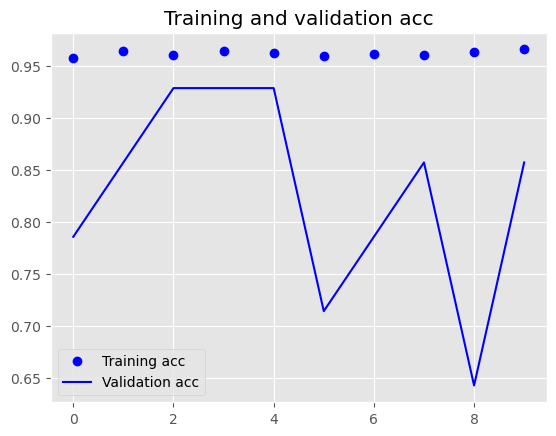

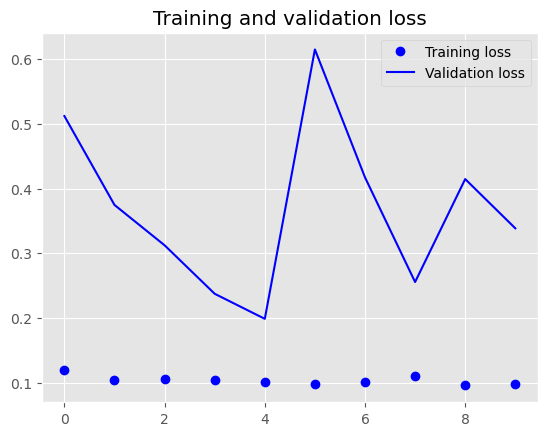

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 395ms/step - accuracy: 0.9455 - loss: 0.2215
Accuracy en test: 0.9263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9286 - loss: 0.1986
Accuracy en validación: 0.9286


In [45]:
# 1. Entrenamiento (ya realizado)
acc = history.history['accuracy']           # Accuracy en training por cada epoch
val_acc = history.history['val_accuracy']   # Accuracy en validation por cada epoch
loss = history.history['loss']              # Loss en training por cada epoch
val_loss = history.history['val_loss']      # Loss en validation por cada epoch

# 2. Visualización de la evolución durante el entrenamiento
print(f"Avg. Train Accuracy: {round(np.mean(acc),3)*100}")
print(f"Avg. Test Accuracy: {round(np.mean(val_acc),4)*100}")
print(f"Avg. Train Loss: {round(np.mean(loss),3)*100}")
print(f"Avg. Test Loss: {round(np.mean(val_loss),4)*100}")

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 3. Evaluación final con conjunto de test
test_loss, test_acc = classifier.evaluate(testing_dataset)
print(f"Accuracy en test: {test_acc:.4f}")

# 4. Evaluación final con conjunto de validación
val_loss, val_acc = classifier.evaluate(validation_dataset)
print(f"Accuracy en validación: {val_acc:.4f}")

CONCLUSIONES:

Optimizamos un modelo de CNN para clasificar radiografías 
de tórax entre normales y con neumonía. El modelo original cumplía con el 
objetivo (accuracy > 80%), pero presentaba signos de sobreajuste.

Tras implementar mejoras (Early Stopping y Data Augmentation mejorado), los 
resultados muestran:

1. Rendimiento:
   Modelo original: 90.71% accuracy en test
   Modelo mejorado: 92.63% accuracy en test

2. Eficiencia: El Early Stopping redujo el tiempo de entrenamiento, parando en la época 10 y evitó el sobreajuste.

3. Estabilidad:
   El modelo mantiene un excelente rendimiento en todos los conjuntos:
   - Training: >95% accuracy consistente
   - Validación: 92.86% accuracy final
   - Test: 92.63% accuracy final

Las fluctuaciones en la validación persisten debido al pequeño tamaño del conjunto (14 imágenes), pero esto no afecta al rendimiento final del modelo en el conjunto de prueba, que es robusto y supera significativamente el objetivo del 80% de precisión.

# 5. Guardar modelo mejorado

In [47]:
classifier.save('pneumonia_model_improved.h5')
print("Modelo mejorado guardado como 'pneumonia_model_improved.h5'")

Modelo mejorado guardado como 'pneumonia_model_improved.h5'


# 6. Predicciones con el modelo mejorado


Analizando radiografías:

Analizando Radio1:


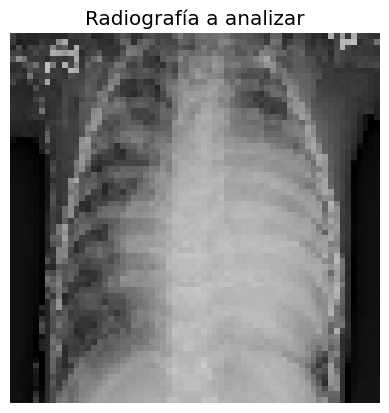

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicción: PNEUMONIA
Probabilidad: 1.0000

Analizando Radio2:


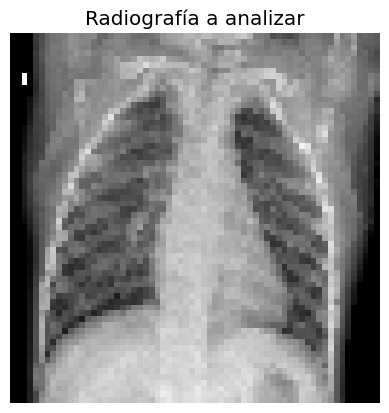

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
Predicción: NORMAL
Probabilidad: 0.9952


In [61]:
# Definimos la ruta completa a la carpeta de predicción
base_dir = "/Users/maruxamoreiraperez/Python/MaruPython/clases julio/modulo 7/Deep learning/data copia/prediccion"
prediccion_dir = os.path.join(base_dir, "prediccion")

def predict_image(img_path):
    """
    Función para predecir si una radiografía muestra neumonía o es normal
    """
    # Cargamos y preparamos la imagen
    img = image.load_img(img_path, target_size=(img_width, img_height))
    
    # Mostramos la imagen
    plt.imshow(img)
    plt.title("Radiografía a analizar")
    plt.axis('off')
    plt.show()
    
    # Convertimos la imagen para la predicción
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    
    # Hacemos la predicción
    prediction = classifier.predict(img_array)
    
    # Interpretamos el resultado
    result = "PNEUMONIA" if prediction[0][0] > 0.5 else "NORMAL"
    probability = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]
    
    print(f"Predicción: {result}")
    print(f"Probabilidad: {probability:.4f}")

# Probamos con las radiografías de predicción
print("\nAnalizando radiografías:")

# Analizamos Radio1.jpeg
img_path = os.path.join(base_dir, "Radio1.jpeg")
print("\nAnalizando Radio1:")
predict_image(img_path)

# Analizamos Radio2.jpeg
img_path = os.path.join(base_dir, "Radio2.jpeg")
print("\nAnalizando Radio2:")
predict_image(img_path)

# 7. CONCLUSIÓN FINAL

El modelo de Deep Learning desarrollado cumple el objetivo del ejercicio, 
alcanzando un 92.63% de accuracy en test y demostrando excelente capacidad de 
predicción con las nuevas imágenes, con probabilidades superiores al 99%. Las mejoras 
implementadas (Early Stopping y Data Augmentation) han contribuido a crear un modelo 
robusto y eficiente para la clasificación de radiografías de tórax.